# COMPARATIVE ANALYSIS
This notebook takes the DESeq2 outputs for each of the seven focal ant species in our screen, as well as the table of ortholog groups from OrthoMCL. It calculates the observed number of concordant differentially expressed genes across all combinations of species. It also identifies the genes that are concordantly differentially expressed in any subset of five species. 

## Table of Contents
1.  Create data frames of p_values for all species
2.  Create table of orthologs
3.  Create new columns to allow filtering to single copy orthologs
4.  Join the p-value files together
5.  Check table for all significant genes
6.  Check number of orthologous DEGs per species
7.  Find number of concordant DEGs
8.  Calculate average concordance
9.  Concordance simulations
10.  combine both datasets

In [1]:
from itertools import combinations
import os

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd

## Create table of single copy ant orthologs and their differential expression

### Create data frames of p_values for all species

In [4]:
# create name lists for readability of tables:
species =   ['Acromyrmex',
             'Camponotus',
             'Dinoponera',
             'Harpegnathos',
             'Odontomachus',
             'Ooceraea',
             'Solenopsis'
            ]
sp_short = ['Aech', 'Cpla', 'Dqua', 'Hsal', 'Orug', 'Obir', 'Sinv']

# define the file names of all DESeq2 output files:
all_pvalues =   ['Acromyrmex_echinatior_deseq.txt',
                 'Camponotus_planatus_deseq.txt',
                 'Dinoponera_quadriceps_deseq.txt',
                 'Harpegnathos_saltator_deseq.txt',
                 'Odontomachus_ruginodis_deseq.txt',
                 'Ooceraea_biroi_deseq.txt',
                 'Solenopsis_invicta_deseq.txt'
                ]

# specify the orthomcl output file:
orthologs = os.path.join('orthomcl_output', 'mclGroups.txt')

In [5]:
# create a dictionary of dataframes, with key being the genus.
df_pval_dic = { sp:pd.read_csv(os.path.join('DESeq2_output',fp), 
                               sep=' ', 
                               index_col=0
                              ) for sp, fp in zip(species,all_pvalues) 
              }

In [6]:
for sp in species:
    print("{:<13s}:{:5} genes, {} columns".format(sp, df_pval_dic[sp].shape[0], df_pval_dic[sp].shape[1]))

Acromyrmex   :12176 genes, 6 columns
Camponotus   :17993 genes, 6 columns
Dinoponera   :11544 genes, 6 columns
Harpegnathos :12302 genes, 6 columns
Odontomachus :25458 genes, 6 columns
Ooceraea     :13640 genes, 6 columns
Solenopsis   :15103 genes, 6 columns


In [7]:
# display first 5 rows of dataframe to check content
df_pval_dic['Acromyrmex'].head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Aech|LOC105144162,5933.902081,4.016824,0.181735,-22.102647,2.980722e-108,3.172383e-104
Aech|LOC105148307,351.575222,3.927635,0.217894,-18.025465,1.229748e-72,6.544105e-69
Aech|LOC105149897,84.006564,6.540987,0.414533,-15.779186,4.327312e-56,1.535186e-52
Aech|LOC105152929,85.273274,5.542425,0.364529,-15.204351,3.308932e-52,8.804242e-49
Aech|LOC105151872,1400.529397,4.216169,0.317197,-13.291948,2.577796e-40,5.487098e-37


### Identify single copy orthologs

In [8]:
# create dataframe of orthologs from orthomcl output
df_orthologs = pd.read_csv(orthologs, 
                           sep=':', 
                           header=None, 
                           names=["group","orthologs"])
df_orthologs.head()

,group,orthologs
0,ILPpaperGroups1000,Aech|LOC105155080 Obir|LOC105287483 Sinv|LOC1...
1,ILPpaperGroups1001,Acep|LOC105617370 Acep|LOC105617724 Acep|LOC1...
2,ILPpaperGroups1002,Acep|LOC105617602 Acep|LOC105621803 Acep|LOC1...
3,ILPpaperGroups1003,Acep|LOC105619009 Acep|LOC105619010 Acep|LOC1...
4,ILPpaperGroups1004,Acep|LOC105619475 Dqua|LOC106746452 Lhum|LOC1...


Create new columns to allow filtering to single copy orthologs

In [9]:
# create column with number of orthologs in group:
df_orthologs["group_size"] = df_orthologs.apply(lambda s: len(s["orthologs"].split()), axis=1)

# group size only counting the 7 ant species of interest:
df_orthologs["group_size_7"] = df_orthologs.apply(lambda s: len([o for o in s["orthologs"].split() if o[:4] in sp_short]), axis=1)

# create column with number of unique species present:
df_orthologs["group_size_unique"] = df_orthologs.apply(lambda s: len(set([g[:4] for g in s['orthologs'].split()])), axis=1)

# unique set of 7 ant species:
df_orthologs["group_size_7_unique"] = df_orthologs.apply(lambda s: len(set([g[:4] for g in s['orthologs'].split() if g[:4] in sp_short])), axis=1)

In [10]:
df_orthologs.head()

,group,orthologs,group_size,group_size_7,group_size_unique,group_size_7_unique
0,ILPpaperGroups1000,Aech|LOC105155080 Obir|LOC105287483 Sinv|LOC1...,1084,295,16,7
1,ILPpaperGroups1001,Acep|LOC105617370 Acep|LOC105617724 Acep|LOC1...,277,112,18,7
2,ILPpaperGroups1002,Acep|LOC105617602 Acep|LOC105621803 Acep|LOC1...,260,99,18,7
3,ILPpaperGroups1003,Acep|LOC105619009 Acep|LOC105619010 Acep|LOC1...,241,106,18,7
4,ILPpaperGroups1004,Acep|LOC105619475 Dqua|LOC106746452 Lhum|LOC1...,215,76,15,7


Create a subset of the table above, which includes only single copy orthologs across the seven ant species being analyzed. (SCAOs = "Single Copy Ant Orthologs"). Orthologs were determined by orthomcl analysis of the following Insect genomes:

**Ants**
* Acromyrmex echinatior    
* Atta cephalotes
* Camponotus floridanus  
* Camponotus planatus  
* Dinoponera quadriceps  
* Harpegnathos saltator  
* Linepithema humile  
* Monomorium pharaonis  
* Odonotomachus ruginodis  
* Ooceraea biroi  
* Pogonomyrmex barbatum  
* Solenopsis invicta  
* Vollenhovia emeryii
* Wasmannia auropunctata

**Bees**
* Apis mellifera

**Wasps**
* Nasonia vitripennis  
* Polistes canadensis  

**Diptera**
* Drosophila melanogaster  


In [11]:
scaos = df_orthologs[(df_orthologs.group_size_7 == 7) & (df_orthologs.group_size_7_unique == 7)]

In [12]:
scaos.shape

(5581, 6)

### Join the p-value files together
All files will be indexed by ortholog group. First, we separate the single copy ant orthologs into columns for each of their respective species

In [13]:
df_combined = scaos.apply(lambda s: pd.Series(sorted([o for o in s["orthologs"].split() if o[:4] in sp_short])), axis=1)
df_combined.columns = sorted(sp_short)

In [14]:
df_combined.head()

,Aech,Cpla,Dqua,Hsal,Obir,Orug,Sinv
305,Aech|LOC105153097,Cpla|SGF61405,Dqua|LOC106749891,Hsal|LOC105181067,Obir|LOC105281216,Orug|SGF68562,Sinv|LOC105201217
331,Aech|LOC105144379,Cpla|SGF47786,Dqua|LOC106743402,Hsal|LOC105181117,Obir|LOC105282301,Orug|SGF65534,Sinv|LOC105194815
367,Aech|LOC105154742,Cpla|SGF57622,Dqua|LOC106742675,Hsal|LOC105184475,Obir|LOC105281047,Orug|SGF78634,Sinv|LOC105203057
413,Aech|LOC105151083,Cpla|SGF65369,Dqua|LOC106742289,Hsal|LOC105180743,Obir|LOC105287676,Orug|SGF86030,Sinv|LOC105198509
423,Aech|LOC105149040,Cpla|SGF52740,Dqua|LOC106748414,Hsal|LOC105185999,Obir|LOC105277964,Orug|SGF81562,Sinv|LOC105200782


Now we append the mean expression, the log2 fold-change between reproductive and non-reproductive castes, the p-value and FDR-corrected p-values from the DESeq2 analyses.

In [15]:
cols_to_join = ["baseMean","log2FoldChange","pvalue","padj"]   #note that pvalue is the unadjusted pval, and padj is p after fdr correction
for sp,gen in zip(sp_short,species):
    p_to_join = df_pval_dic[gen][cols_to_join]
    p_to_join.columns = [ "{}_{}".format(sp,c) for c in cols_to_join]
    df_combined = df_combined.join(p_to_join, how='left', on=sp)

In [16]:
df_combined.head()

,Aech,Cpla,Dqua,Hsal,Obir,Orug,Sinv,Aech_baseMean,Aech_log2FoldChange,Aech_pvalue,...,Orug_pvalue,Orug_padj,Obir_baseMean,Obir_log2FoldChange,Obir_pvalue,Obir_padj,Sinv_baseMean,Sinv_log2FoldChange,Sinv_pvalue,Sinv_padj
305,Aech|LOC105153097,Cpla|SGF61405,Dqua|LOC106749891,Hsal|LOC105181067,Obir|LOC105281216,Orug|SGF68562,Sinv|LOC105201217,839.829550,-0.005591,9.749647e-01,...,0.323920,0.471735,2227.754133,0.432653,0.002878,0.041655,391.232256,-0.051518,0.421668,0.585876
331,Aech|LOC105144379,Cpla|SGF47786,Dqua|LOC106743402,Hsal|LOC105181117,Obir|LOC105282301,Orug|SGF65534,Sinv|LOC105194815,244.784487,1.460857,2.037000e-08,...,0.836298,0.891570,793.978290,-0.007736,0.963926,0.992221,226.248598,0.423662,0.000122,0.000781
367,Aech|LOC105154742,Cpla|SGF57622,Dqua|LOC106742675,Hsal|LOC105184475,Obir|LOC105281047,Orug|SGF78634,Sinv|LOC105203057,306.311466,-0.077285,6.244275e-01,...,0.000001,0.000016,2189.024661,-0.103909,0.607203,0.871456,407.541439,0.260069,0.005161,0.019039
413,Aech|LOC105151083,Cpla|SGF65369,Dqua|LOC106742289,Hsal|LOC105180743,Obir|LOC105287676,Orug|SGF86030,Sinv|LOC105198509,92.576057,0.841557,8.401890e-03,...,0.463778,0.605464,83.684642,-0.166003,0.461690,0.789415,45.880269,0.219733,0.386031,0.551058
423,Aech|LOC105149040,Cpla|SGF52740,Dqua|LOC106748414,Hsal|LOC105185999,Obir|LOC105277964,Orug|SGF81562,Sinv|LOC105200782,102.323539,1.464132,3.364315e-10,...,0.471751,0.612367,1136.701183,0.179205,0.234553,0.608615,867.414114,0.762431,0.000251,0.001467


In [17]:
# save to file. This table constitutes Supplementary Table X
df_combined.to_csv("ortholog_pvalue_table.csv", index=False)

## Identify all concordant differentially expressed genes

In [18]:
pcols = ["{}_{}".format(sp,"padj") for sp in sp_short] # a list of all the pvalue columns
lfc_cols = [ "{}_log2FoldChange".format(s) for s in sp_short ] # a list of all the LFC columns

mask = (df_combined[pcols] <= 0.05).all(axis=1)

print("{} orthologs found with all p-values (adjusted) <= 0.05".format(mask.sum()))
df_combined[mask]


1 orthologs found with all p-values (adjusted) <= 0.05


,Aech,Cpla,Dqua,Hsal,Obir,Orug,Sinv,Aech_baseMean,Aech_log2FoldChange,Aech_pvalue,...,Orug_pvalue,Orug_padj,Obir_baseMean,Obir_log2FoldChange,Obir_pvalue,Obir_padj,Sinv_baseMean,Sinv_log2FoldChange,Sinv_pvalue,Sinv_padj
2059,Aech|LOC105147653,Cpla|SGF53173,Dqua|LOC106750697,Hsal|LOC105188195,Obir|LOC105278524,Orug|SGF66168,Sinv|LOC105200753,68.272121,2.711926,6.766716e-12,...,0.000927,0.004607,1228.728806,1.381716,4.212394e-18,2.963560e-15,626.264624,2.441594,4.785615e-18,3.473843e-16


This last cell shows that there is only one gene that has a p-value (FDR adjusted) ≤ 0.05 in all seven species. This gene is also over-expressed in reproductives in all seven species (ie, it is concordantly expressed in all seven species).

### Interactively check table for all significant genes
This section allows you to interactively view the effect of different significance thresholds and their effect on the number of genes significant in all species. You will need to have enabled ipywidgets in your notebook to use this section (see [here](http://ipywidgets.readthedocs.io/en/latest/user_install.html) for details)

In [19]:
from ipywidgets import interact, interact_manual
import ipywidgets as widgets

In [20]:
pcols = ["{}_{}".format(sp,"padj") for sp in sp_short]         # a list of all the pvalue columns
lfc_cols = [ "{}_log2FoldChange".format(s) for s in sp_short ] # a list of all the LFC columns

In [21]:
def set_pvalue(thresh=0.05):
    mask = (df_combined[pcols] <= thresh).all(axis=1)
    print("{} ortholog(s) found with all p-values (adjusted) <= {}".format(mask.sum(), thresh))
    return df_combined[mask]

In [22]:
interact(set_pvalue, thresh=(0.0,1.0,0.01) );  # widgets.FloatSlider(min=0.,max=0.5,step=0.01,value=0.05));

interactive(children=(FloatSlider(value=0.05, description='thresh', max=1.0, step=0.01), Output()), _dom_class…

### Check number of orthologous DEGs per species
The number of orthologous DEGs will be smaller than the total number of DEGs for each individual species, since only the single-copy orthologs are represented.

In [23]:
pvs = [ sp + "_padj" for sp in sp_short]
species_specific_deg_num = []  # this variable is used later for the simulations
print("{0:<13s} {2:<6s} {1:<4s} {3:<4s}".format("SPECIES", "ODEGs", "DEGs", "(%)"))
for p,sp in zip(pvs, species):
    species_specific_deg_num.append((df_combined[p] <= 0.05).sum())
    print("{0:<13s} {2:-5d} {1:-5d}  {3:.1f}".format(sp, 
                                         (df_combined[p] <= 0.05).sum(), 
                                         (df_pval_dic[sp]["padj"] <= 0.05).sum(),
                                         100*(df_combined[p] <= 0.05).sum() / (df_pval_dic[sp]["padj"] <= 0.05).sum()
                                        )
         )

SPECIES       DEGs   ODEGs (%) 
Acromyrmex     2262  1050  46.4
Camponotus     5304  2579  48.6
Dinoponera      408   171  41.9
Harpegnathos     35    16  45.7
Odontomachus   4987  2270  45.5
Ooceraea        784   363  46.3
Solenopsis     4116  1925  46.8


### Display fold-change and p values

show values for Insulin-like peptides 1 and 2:

In [24]:
df_combined[df_combined.Obir == "Obir|LOC105283606"][pvs + lfc_cols]  # ILP1 

,Aech_padj,Cpla_padj,Dqua_padj,Hsal_padj,Orug_padj,Obir_padj,Sinv_padj,Aech_log2FoldChange,Cpla_log2FoldChange,Dqua_log2FoldChange,Hsal_log2FoldChange,Orug_log2FoldChange,Obir_log2FoldChange,Sinv_log2FoldChange
8648,0.022555,0.006219,0.58577,0.000114,0.120454,0.02609,0.000009,-1.193374,-0.758144,-0.483432,-1.719643,-0.750206,-0.759376,-1.308077


In [25]:
df_combined[df_combined.Obir == "Obir|LOC105278524"][pvs + lfc_cols]  # ILP2

,Aech_padj,Cpla_padj,Dqua_padj,Hsal_padj,Orug_padj,Obir_padj,Sinv_padj,Aech_log2FoldChange,Cpla_log2FoldChange,Dqua_log2FoldChange,Hsal_log2FoldChange,Orug_log2FoldChange,Obir_log2FoldChange,Sinv_log2FoldChange
2059,4.391351e-10,0.019167,0.037204,0.013436,0.004607,2.963560e-15,3.473843e-16,2.711926,1.081158,1.086033,0.898978,1.123209,1.381716,2.441594


In [26]:
def view_gene(choice="Obir|LOC105278524"):   # default is ILP2
    # plot the log2FoldChange of all genes of interest
    df = df_combined[df_combined.Obir == choice]
    if len(df) == 0:
        return "No gene found"
    
    ax = df[["Obir"] + lfc_cols].set_index("Obir").plot.bar(figsize=(10,5))

    # get the pvalues of these genes:
    df_cpvals = df[["Obir"] + pvs].set_index("Obir")

    # annotate the signicantly differentially expressed genes with an asterisk
    x_pos = [rect.get_x() + rect.get_width()/2. for rect in ax.patches]
    y_pos = [rect.get_y() + rect.get_height() -0.35 + 0.2*(rect.get_height())/abs(rect.get_height()) for rect in ax.patches]
    scores = [{1:"*",0:""}[p<=0.05] for p in df_cpvals.values.flatten("F")]
    for rect, x, y, s in zip(ax.patches, x_pos, y_pos, scores):
            ax.text(x, 
                    y,
                    s,
                    ha='center', va='bottom',
                    size=32,
                    color='r'
                   )

    # add axes labels
    plt.ylabel("log2(fold-change)", size=16)
    plt.yticks(size=14)
    plt.xlabel(ax.get_xticklabels()[0].get_text(), size=16)
    plt.xticks([], [])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, prop={'size': 16});

### interactively view results for a single ortholog group
In the text box below, enter the 4-letter species code plus gene ID for any gene in the single-copy ortholog table, and it will display the log-fold changes and indicate whether the gene is significantly differentially expressed.

In [27]:
interact_manual(view_gene, choice="Obir|LOC105278524");

interactive(children=(Text(value='Obir|LOC105278524', description='choice'), Button(description='Run Interact'…

## Concordant DEGs analysis
While there is only a single gene differentially expressed across all seven species, there are varied numbers of genes significant and concordant among all the combinations of those seven species. Attempting to draw a Venn diagram would be of little use, as it becomes difficult to evaluate each comparison and see trends among so many sets.
Thus, here we will identify the number of genes that are signficant and concordant for each possible combination of the seven species, and plot the values against the number of species compared.

In [28]:
c = {i:[] for i in np.arange(len(species)) + 1}
for n in np.arange(len(species)) + 1:
    for combo in combinations(zip(pcols,lfc_cols), n):
        ps,ls = list(zip(*combo))
        ps = list(ps)
        ls = list(ls)
        concordant_degs = ((
                            df_combined[ps] <= 0.05
                             ).all(axis=1) & (
                            abs((df_combined[ls] / abs(df_combined[ls])).sum(axis=1)) == len(ls)
                                        ) 
                            )
        #print("# sp = {0} # cdegs = {1}".format(len(ls), concordant_degs.sum()))
        c[n].append(concordant_degs.sum())
df_cdegs = pd.DataFrame({ k:pd.Series(v) for k,v in c.items()})

In [29]:
df_cdegs

,1,2,3,4,5,6,7
0,1050.0,386.0,11,2,2.0,1.0,1.0
1,2579.0,31.0,5,5,1.0,2.0,NaN
2,171.0,7.0,197,3,2.0,1.0,NaN
3,16.0,276.0,41,7,2.0,2.0,NaN
4,2270.0,88.0,249,2,4.0,1.0,NaN
5,363.0,542.0,2,2,2.0,1.0,NaN
6,1925.0,57.0,13,5,1.0,1.0,NaN
7,NaN,7.0,3,23,2.0,NaN,NaN
8,NaN,1346.0,18,130,2.0,NaN,NaN
9,NaN,123.0,2,32,18.0,NaN,NaN


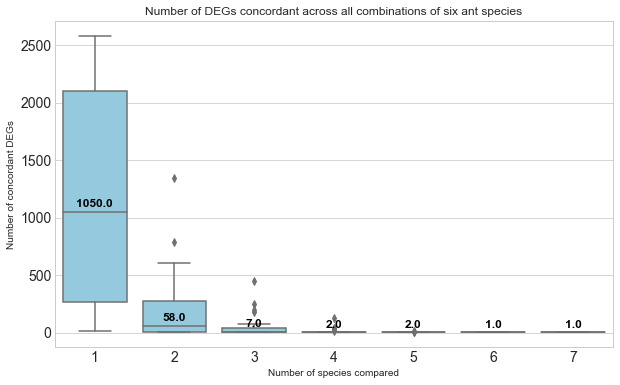

In [30]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(data=df_cdegs, color="skyblue", ax=ax)

medians = df_cdegs.median().values
median_labels = [str(x) for x in medians]

pos = np.arange(len(medians)) 
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 
            medians[tick] + 40, 
            median_labels[tick], 
            horizontalalignment='center', size=12, color='k', weight='semibold')
    
    
plt.title("Number of DEGs concordant across all combinations of six ant species")
plt.xlabel("Number of species compared")
plt.ylabel("Number of concordant DEGs")
plt.xticks(size=14)
plt.yticks(size=14)
plt.savefig("concordant_degs_observed.png")
plt.show()

### Calculate average concordance

In [31]:
lfc = [ sp + "_log2FoldChange" for sp in sp_short ]
# convert log fold changes into the direction:
df_direction = df_combined[lfc] / abs(df_combined[lfc])

# count number of genes concordant across all spp:
print("{:.2f}% of genes are concordant in all {:d} species".format(
            100 * (abs(df_direction.sum(axis=1)) == len(species)).sum() / len(df_direction),
            len(species))
     )

4.75% of genes are concordant in all 7 species


In [32]:
conc_list = []
for sp1,sp2 in combinations(lfc,2):
    conc_list.append((abs(df_direction[[sp1,sp2]].sum(axis=1)) == 2).sum() / len(df_direction))
    print("{}|{} {:.2f}%".format(sp1[:4],sp2[:4],100*conc_list[-1]))
print("{:.2f}% average concordance between any two genes".format(np.mean(conc_list) * 100))

Aech|Cpla 60.54%
Aech|Dqua 52.41%
Aech|Hsal 41.46%
Aech|Orug 58.75%
Aech|Obir 55.37%
Aech|Sinv 66.42%
Cpla|Dqua 54.38%
Cpla|Hsal 36.95%
Cpla|Orug 77.98%
Cpla|Obir 56.94%
Cpla|Sinv 59.13%
Dqua|Hsal 52.95%
Dqua|Orug 53.81%
Dqua|Obir 50.82%
Dqua|Sinv 53.06%
Hsal|Orug 37.66%
Hsal|Obir 49.27%
Hsal|Sinv 46.01%
Orug|Obir 56.84%
Orug|Sinv 57.55%
Obir|Sinv 60.63%
54.24% average concordance between any two genes


## Generate heatmap of genes that are differentially expressed in any subset of five species
To investigate the impact of individual species on the comparative analysis, we can systematically remove two species from our list of seven, and look at the resultant lists of concordant DEGs.

In [33]:
#set (adjusted) pvalue threshold
pthresh = 0.05

#set number of species [between 1 and 7]
spnum = 5

In [34]:
def filter_subset(s, spnum=5, pthresh=0.05):
    """
    This function operates on a series of pvals and log fold changes (in 
    that order). It     finds all pvals less than the threshold, then 
    looks to see if there are     at least as many concordant genes as 
    in the subset number. If so, it returns true - ie, there are at 
    least spnum species concordant and signficantly differentially 
    expressed for this gene.
    """
    mask = s[:7]<=0.05
    mask.set_axis(lfc_cols, inplace=True)
    num_upreg = (s[7:][mask]>0).sum()
    num_downreg = (s[7:][mask]<0).sum()
    
    if num_downreg >= spnum or num_upreg >= spnum:  # can be concordant up or down
        return True
    else:
        return False

In [35]:
subset_mask = df_combined[pcols+lfc_cols].apply(filter_subset, args=(spnum,pthresh), axis=1)

In [36]:
print("There are {} unique genes that are differentially expressed among subsets of {} species".format(subset_mask.sum(), spnum)) 

There are 24 unique genes that are differentially expressed among subsets of 5 species


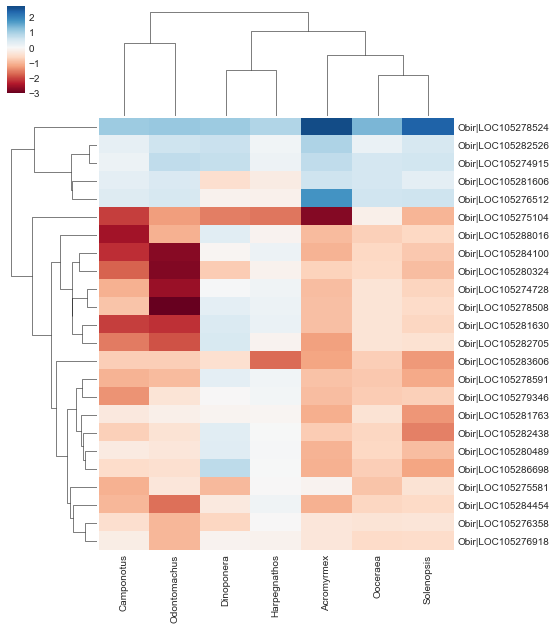

In [37]:
ax = sns.clustermap(df_combined[subset_mask][lfc_cols], 
                    figsize=(8,10), 
                    yticklabels=df_combined[subset_mask]['Obir'].values,
                    xticklabels=species,
                    cmap='RdBu',
                    center=0,
                   )

In [38]:
df_combined[df_combined.Obir == "Obir|LOC105282526"][pcols]

,Aech_padj,Cpla_padj,Dqua_padj,Hsal_padj,Orug_padj,Obir_padj,Sinv_padj
2273,0.000185,0.040483,0.001509,0.947267,1.205808e-12,0.567974,8.383073e-07
